In [2]:
import os # for making directories
import requests

pdb_id = "7LME"

# make a directory for pdb files
protein_directory = "protein_structures"
os.makedirs(protein_directory, exist_ok=True)
os.makedirs("pdbqt", exist_ok=True)

pdb_request = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb")
pdb_request.status_code

200

In [3]:
with open(f"{protein_directory}/{pdb_id}.pdb", "w+") as f:
    f.write(pdb_request.text)

In [5]:
# We will prepare this structure using PDBFixer because there are missing residues
# for our previous workshop, we had only missing atoms so PDB2PQR was sufficient
# but here we have missing atoms and missing residues
# Swithed to PDBFixer Python API so that we can use a forcefield to do an energy minimiation.
# This is necessary because otherwise, other tools later in the pipeline will get "confused" by hydrogen positions, thinking they
# have more bonds than they do. PDBFixer/OpenMM know the correct bonding on initial PDB read because CONECT records are present in the PDB file.

from pdbfixer import PDBFixer
from openmm.app import PDBFile, Simulation, ForceField
from openmm import Platform, VerletIntegrator
from openmm import unit

# Fix structure using PDBFixer
fixer = PDBFixer(filename='protein_structures/7LME.pdb')
forcefield = ForceField("amber/protein.ff14SB.xml")

fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(keepWater=False)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(forcefield=forcefield)

# Create OpenMM system for minimization
system = forcefield.createSystem(fixer.topology)

# Use a generic VerletIntegrator
integrator = VerletIntegrator(0.001 * unit.picoseconds)

# Create simulation for minimization
platform = Platform.getPlatformByName('CPU')
simulation = Simulation(fixer.topology, system, integrator, platform)
simulation.context.setPositions(fixer.positions)

# Minimize energy
print('Minimizing energy...')
simulation.minimizeEnergy()

# Get minimized positions
minimized_positions = simulation.context.getState(getPositions=True).getPositions()

# Write minimized structure to a PDB file
with open('protein_structures/7LME_fixed.pdb', 'w') as output:
    PDBFile.writeFile(fixer.topology, minimized_positions, output)

print('Minimization complete. Minimized structure saved to protein_structures/7LME_fixed.pdb.')


Minimizing energy...
Minimization complete. Minimized structure saved to protein_structures/7LME_fixed.pdb.


In [10]:
# We'll use meeko to prepare the receptor.
!mk_prepare_receptor.py --read_pdb protein_structures/7LME_fixed.pdb -o pdbqt/7LME -p


Files written:
pdbqt/7LME.pdbqt <-- static (i.e., rigid) receptor input file


In [ ]:
!pip install git+https://github.com/forlilab/molscrub.git@develop

In [11]:
import pandas as pd
from rdkit import Chem
df = pd.read_csv("US20240293380_examples.csv")
names = df["Name"].str.split().str[1:].str.join("_")
df["Compound Name"] = names

df[["SMILES", "Compound Name"]].to_csv("US20240293380_picked.smi", index=False, header=False, sep=" ")

In [12]:
!scrub.py US20240293380_picked.smi -o mols.sdf

Scrub completed.
Summary of what happened:
Input molecules supplied: 5
mols processed: 5, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 6 (avg. 1.200 per mol)
nr conformers:  6 (avg. 1.000 per isomer, 1.200 per mol)


In [13]:
import mols2grid

mols2grid.display("mols.sdf",
                tooltip=["SMILES"],
                size=(250, 250),

)

In [14]:
!mk_prepare_ligand.py -i mols.sdf --multimol_outdir pdbqt


Maybe this molecule is "too" symmetric? Compound_63 CC(C)(C)NC(=O)[C@H](c1cc(F)cc(F)c1)N(C(=O)Cc1cncc2ccccc12)c1ccc(C2=CC[NH2+]C2)cc1
Input molecules processed: 6, skipped: 0
PDBQT files written: 6
PDBQT files not written due to error: 0
Input molecules with errors: 0
No duplicate molecule molecule names were found


In [15]:
# find the center of the ligand
import MDAnalysis as mda

original_structure = mda.Universe("protein_structures/7LME.pdb")
ligand_mda = original_structure.select_atoms("resname Y6J and segid A")

# Get the center of the ligand as the "pocket center"
pocket_center = ligand_mda.center_of_geometry()
print(pocket_center)

[25.63225802 -1.05319356 15.1893225 ]


In [16]:
# compute min and max coordinates of the ligand
# take the ligand box to be the difference between the max and min in each direction.
ligand_box = ligand_mda.positions.max(axis=0) - ligand_mda.positions.min(axis=0) + 5
ligand_box

array([15.361, 14.059, 15.9  ], dtype=float32)

In [17]:
import nglview as nv
import numpy as np

# Compute the box corners based on the center and size
half_size = ligand_box / 2.0

x1, x2 = pocket_center[0] - half_size[0], pocket_center[0] + half_size[0]
y1, y2 = pocket_center[1] - half_size[1], pocket_center[1] + half_size[1]
z1, z2 = pocket_center[2] - half_size[2], pocket_center[2] + half_size[2]


In [18]:
# Select protein atoms
protein = original_structure.select_atoms("protein")
ligand = original_structure.select_atoms("resname Y6J and segid A")
water = original_structure.select_atoms("resname HOH")

view = nv.show_mdanalysis(protein)
view.clear_representations()
view.add_representation("surface", colorScheme="hydrophobicity")
lig_view = view.add_component(ligand)
lig_view.add_representation("ball+stick")
water_view = view.add_component(water)
water_view.add_representation("spacefill")
view


NGLWidget()

In [19]:
# Define the 12 edges of the box by connecting the corners
edges = [
    ([x1, y1, z1], [x2, y1, z1]),  # Bottom face
    ([x2, y1, z1], [x2, y2, z1]),
    ([x2, y2, z1], [x1, y2, z1]),
    ([x1, y2, z1], [x1, y1, z1]),

    ([x1, y1, z2], [x2, y1, z2]),  # Top face
    ([x2, y1, z2], [x2, y2, z2]),
    ([x2, y2, z2], [x1, y2, z2]),
    ([x1, y2, z2], [x1, y1, z2]),

    ([x1, y1, z1], [x1, y1, z2]),  # Vertical edges
    ([x2, y1, z1], [x2, y1, z2]),
    ([x2, y2, z1], [x2, y2, z2]),
    ([x1, y2, z1], [x1, y2, z2])
]

# Add cylinders for each edge using the correct format
for start, end in edges:
    view.shape.add_cylinder(start, end, [1, 0, 0], 0.1)  # Red color, radius 0.1
view

NGLWidget(n_components=3)

In [20]:
try:
    pocket_center = pocket_center.tolist()
    ligand_box = ligand_box.tolist()
except:
    pass

In [26]:
os.makedirs("docking_results", exist_ok=True)

In [27]:
from vina import Vina
v = Vina(sf_name="vina")

In [28]:
import glob

In [29]:
compounds = glob.glob("pdbqt/Compound*.pdbqt")
print(compounds)

['pdbqt/Compound_12_i0.pdbqt', 'pdbqt/Compound_12_i1.pdbqt', 'pdbqt/Compound_63.pdbqt', 'pdbqt/Compound_1.pdbqt', 'pdbqt/Compound_83.pdbqt', 'pdbqt/Compound_4.pdbqt']


In [30]:
# Question and Answer Here

energies = {}
for compound in compounds:
    v.set_receptor(f"{pdbqt_directory}/{pdb_id}.pdbqt")
    v.set_ligand_from_file(compound)
    v.compute_vina_maps(center=pocket_center, box_size=ligand_box)
    v.dock(exhaustiveness=10, n_poses=5)
    compound_name = os.path.basename(compound).split(".")[0]
    v.write_poses(f"docking_results/{compound_name}.pdbqt", n_poses=9)
    energies[compound_name] = v.energies()

Computing Vina grid ... done.
Performing docking (random seed: -1664743127) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -8.68          0          0
   2       -8.663      1.331        2.1
   3       -8.572       3.04      6.481
   4       -8.248       3.17      5.954
   5       -8.197        3.5        6.9
Computing Vina grid ... done.
Performing docking (random seed: -1664743127) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.169          0          0
   2       -8.989      1.351      

In [31]:
# Column names based on AutoDock Vina documentation
column_names = ["total", "inter", "intra", "torsions", "intra best pose"]

# we are going to make a multiindex dataframe - 
# we need to make sure that all the dataframes have the same number of rows
# we will look for the max size so we can pad the smaller ones
max_poses = max(len(values) for values in energies.values())

# create a dictionary of DataFrames, padding with NaN as needed
dfs = {}
for compound, values in energies.items():
    # create DataFrame from the available poses
    df = pd.DataFrame(values, columns=column_names)
    
    # If this compound has fewer poses than max_poses, pad with NaN
    if len(values) < max_poses:
        # Create empty rows to append
        pad_rows = max_poses - len(values)
        pad_df = pd.DataFrame(np.nan, index=range(len(values), max_poses), columns=column_names)
        
        # Concatenate the original and padding DataFrames
        df = pd.concat([df, pad_df])
    
    dfs[compound] = df

# Use pd.concat to create the MultiIndex columns
result_df = pd.concat(dfs, axis=1)

# name the indexes to be pose_1, pose_2, etc.
result_df.index = [f"pose_{i+1}" for i in range(max_poses)]

result_df.head()

Compound_12_i0                                         Compound_12_i1  \
                total   inter  intra torsions intra best pose          total   
pose_1         -8.680 -12.232 -2.563    3.552          -2.563         -9.169   
pose_2         -8.663 -13.034 -1.737    3.545          -2.563         -8.989   
pose_3         -8.572 -13.056 -1.586    3.508          -2.563         -8.968   
pose_4         -8.248 -10.478 -3.708    3.375          -2.563         -8.886   
pose_5         -8.197 -10.502 -3.612    3.354          -2.563         -8.760   

                                                ... Compound_83          \
         inter  intra torsions intra best pose  ...       total   inter   
pose_1 -12.921 -1.764    3.752          -1.764  ...      -7.772 -10.952   
pose_2 -11.891 -2.539    3.678          -1.764  ...      -7.611 -11.083   
pose_3 -12.795 -1.607    3.670          -1.764  ...      -7.493 -10.410   
pose_4 -11.726 -2.561    3.636          -1.764  ...      -7.480 -10.812   
pose_5 -10.633 -3.476    3.585          -1.764  ...      -7.436 -10.790   

                                       Compound_4                          \
        intra torsions intra best pose      total   inter  intra torsions   
pose_1 -1.475    3.180          -1.475     -8.695 -12.254 -1.708    3.558   
pose_2 -1.117    3.114          -1.475     -8.667 -12.175 -1.747    3.547   
pose_3 -1.625    3.066          -1.475     -8.483 -11.991 -1.672    3.471   
pose_4 -1.204    3.061          -1.475     -8.314 -11.800 -1.624    3.402   
pose_5 -1.163    3.043          -1.475     -8.259 -12.180 -1.167    3.380   

                        
       intra best pose  
pose_1          -1.708  
pose_2          -1.708  
pose_3          -1.708  
pose_4          -1.708  
pose_5          -1.708  

[5 rows x 30 columns]

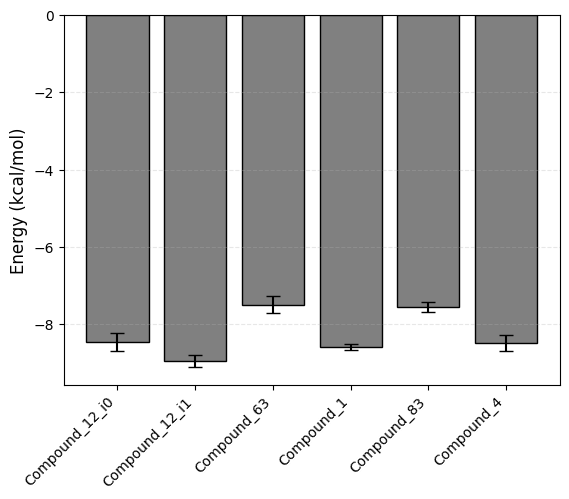

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the minimum total energy for each compound directly
best_energies = result_df.xs('total', level=1, axis=1).mean()
std_dev = result_df.xs("total", level=1, axis=1).std()

# Create a simple bar chart
plt.bar(best_energies.index, best_energies.values, yerr=std_dev.values, capsize=5, color='gray', edgecolor='black')
plt.ylabel('Energy (kcal/mol)', fontsize=12)
plt.xlabel('')  # Remove x-label as it's redundant
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

In [33]:
result_df.to_csv("docking_results/energies.csv")

In [34]:
! mk_export.py docking_results/Compound_12_i0.pdbqt -s docking_results/Compound_12_i0.sdf
#! mk_export.py docking_results/Compound_63.pdbqt -s docking_results/Compound_63.sdf

In [38]:
import prolif as plf
import MDAnalysis as mda

protein = mda.Universe(f"protein_structures/{pdb_id}_fixed.pdb")

bonds =  [(bond.atom1.index, bond.atom2.index) for bond in fixer.topology.bonds()]
protein.add_TopologyAttr('bonds', bonds)

num_atoms = len(protein.atoms)

fixer_atoms = list(fixer.topology.atoms())

for i in range(num_atoms):
    assert protein.atoms[i].element == fixer_atoms[i].element.symbol, f"Element mismatch at atom {i}! {protein.atoms[i].element} != {fixer_atoms[i].element}"
    

In [ ]:
bonds[0]

In [39]:
protein_plf = plf.Molecule.from_mda(protein)
poses_plf = plf.sdf_supplier("docking_results/Compound_12_i0.sdf")

In [40]:
fp = plf.Fingerprint(count=True)


In [41]:
# run on your poses
fp.run_from_iterable(poses_plf, protein_plf)

  0%|          | 0/5 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7f19e2d63690>

In [42]:
pose_index=1

In [43]:
fp.plot_lignetwork(poses_plf[pose_index])

In [44]:
view = fp.plot_3d(
    poses_plf[pose_index], protein_plf, frame=pose_index, display_all=False
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.